Импортирование библиотек

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

Подключение датасета и вывод общей информации

In [ ]:
!gdown 1Y_LmSFF-v0WmF5HJknoo1_2UjrJuzbZV # временная ошибка

Downloading...
From: https://drive.google.com/uc?id=1Y_LmSFF-v0WmF5HJknoo1_2UjrJuzbZV
To: /content/data.csv
100% 2.21M/2.21M [00:00<00:00, 37.6MB/s]


In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head(10)

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation
5,7150000.0,Secondary,Опалиха,6.0,Moscow region,1.0,38.4,18.0,8.0,8.0,18,European-style renovation
6,7400000.0,Secondary,Нахабино,11.0,Moscow region,1.0,33.0,16.0,8.0,7.0,7,European-style renovation
7,7500000.0,Secondary,Строгино,27.0,Moscow region,1.0,25.0,14.8,8.7,16.0,34,European-style renovation
8,7800000.0,Secondary,Красногорская,6.0,Moscow region,1.0,41.8,18.0,10.0,6.0,17,Cosmetic
9,7999999.0,Secondary,Тушинская,35.0,Moscow region,1.0,44.0,19.0,11.0,11.0,24,Designer


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22676 non-null  float64
 1   Apartment type    22676 non-null  object 
 2   Metro station     22676 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22676 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22676 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22676 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Minutes to metro'}>,
        <Axes: title={'center': 'Number of rooms'}>],
       [<Axes: title={'center': 'Area'}>,
        <Axes: title={'center': 'Living area'}>,
        <Axes: title={'center': 'Kitchen area'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'Number of floors'}>, <Axes: >]],
      dtype=object)

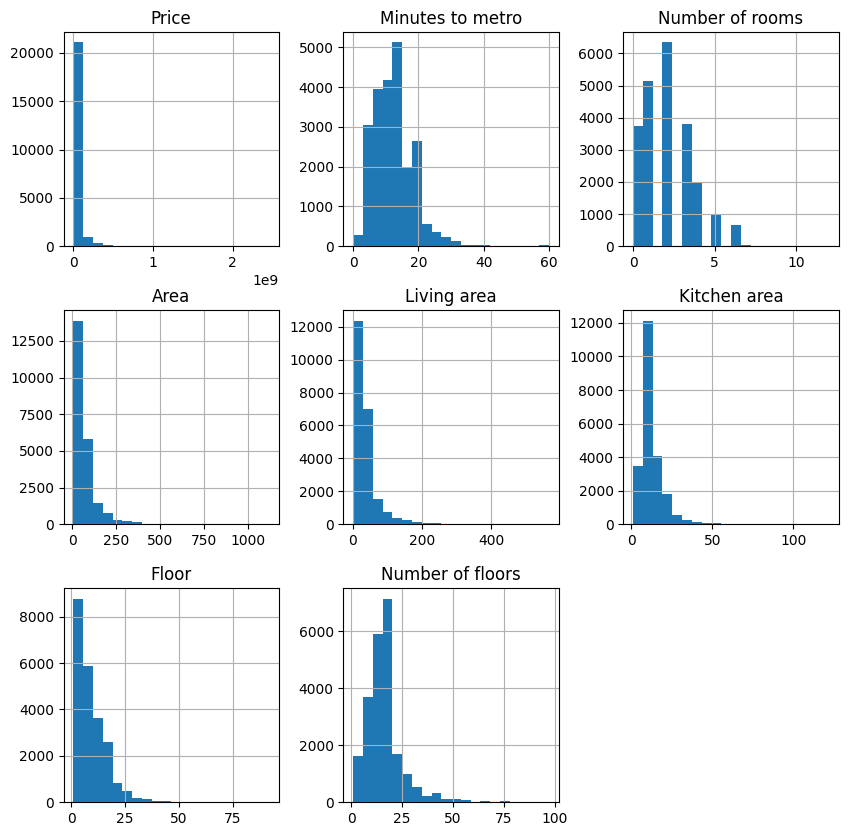

In [ ]:
df.hist(figsize=(10,10), bins=20)

Исправление ошибки с количеством станций метро

In [ ]:
df['Metro station'].nunique() # станций метро в Москве точно меньше

547

In [ ]:
len(set(map(lambda x: x.strip().lower(), df['Metro station'])))

310

In [ ]:
df['Metro station'] = list(map(lambda x: x.strip().lower(), df['Metro station']))

In [ ]:
df['Metro station'].nunique()

310

Анализ значений

<ipython-input-11-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

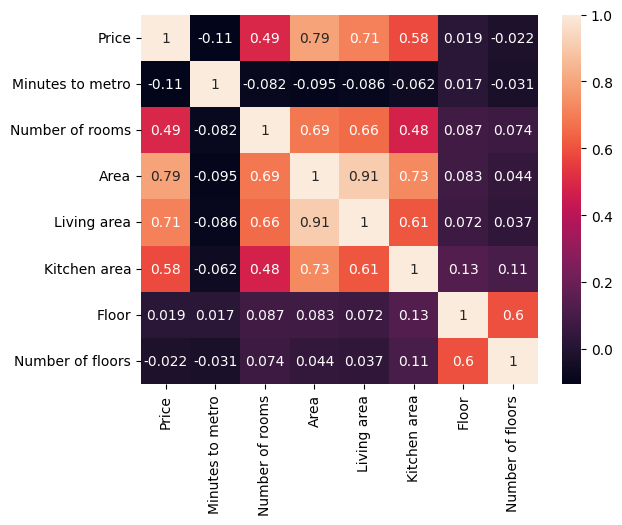

In [ ]:
sns.heatmap(df.corr(), annot=True)

Text(0.5, 1.0, 'Зависимость цены от площади = 0.79')

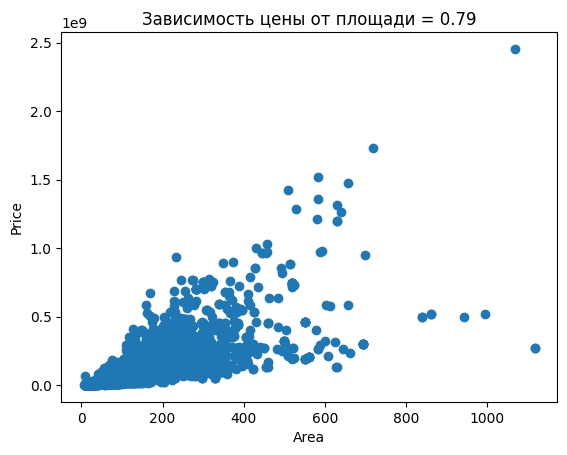

In [ ]:
plt.scatter(df['Area'], df['Price'])
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Зависимость цены от площади = {x}'.format(x=round(df['Price'].corr(df['Area']), 2)))

<Axes: xlabel='Number of rooms', ylabel='Price'>

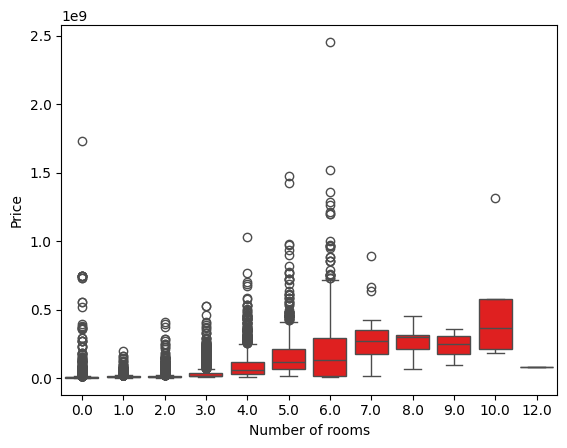

In [ ]:
sns.boxplot(df, x='Number of rooms', y='Price', color='r')

Text(0, 0.5, 'Количество значений')

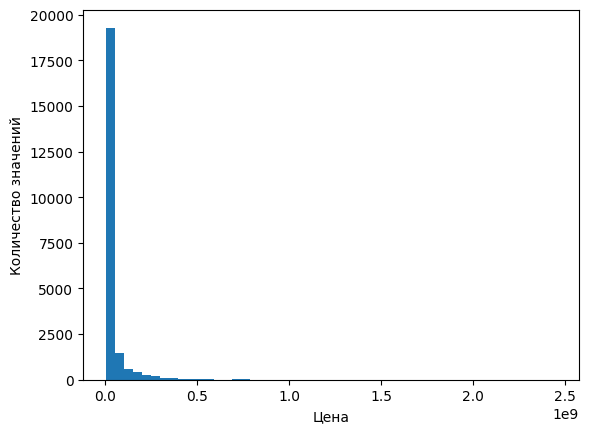

In [ ]:
plt.hist(df['Price'], bins=50)
plt.xlabel('Цена')
plt.ylabel('Количество значений')

<Axes: xlabel='Price', ylabel='Count'>

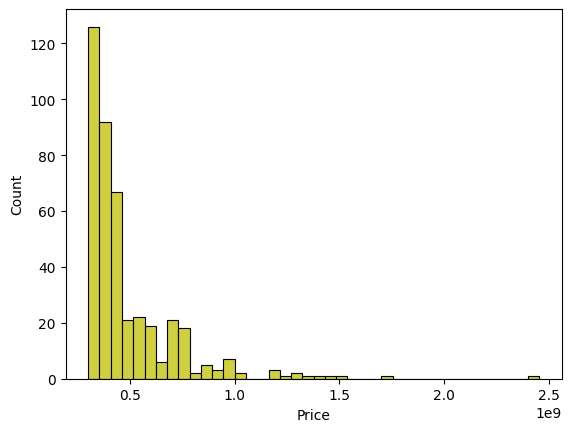

In [ ]:
unpopular = df[df['Price'] >= 0.3 * 10**9] # посмотрим на распределение значений при непопулярных ценах на квартиру
sns.histplot(unpopular['Price'], color='y', bins=40)

<Axes: xlabel='Area', ylabel='Count'>

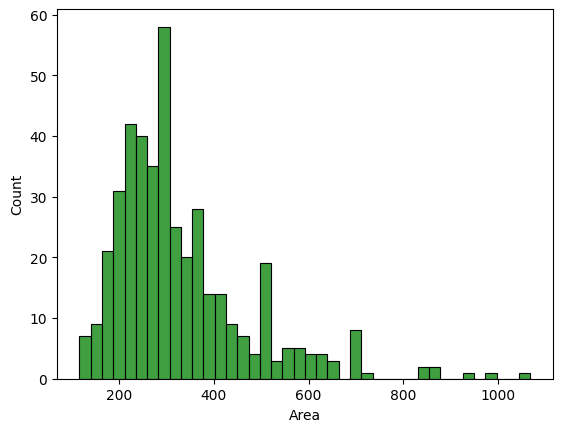

In [ ]:
sns.histplot(unpopular['Area'], color='g', bins=40)

In [ ]:
df_describe = df.describe().T
extreme_values = pd.DataFrame()
list_values = []

for i in df_describe.index:
  treshold = df_describe['75%'].loc[i]  # выделим порог аномальных значений - 75%
  df_part = df[df[i] > treshold] # выберем часть датафрейма, где рассматриваемое значение переходит порог
  df_part = df_part.describe().T  # опишем это значение, чтобы выделить количество значений через столбец count
  list_values.append(df_part['count'].loc[i])  # добавим количество аномальных значений в список

extreme_values.index = df_describe.index
extreme_values['Количество аномальных значений'] = list_values
extreme_values

,Количество аномальных значений
Price,5669.0
Minutes to metro,5392.0
Number of rooms,3648.0
Area,5667.0
Living area,5655.0
Kitchen area,5617.0
Floor,5249.0
Number of floors,4271.0


Как мы видим, количество аномальных значений по всем параметрам примерно одинаковое. Это означает, что эти аномальные значения являются не ошибками в данных, а просто более уникальными случаями

Обучение модели

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, shuffle=True)

In [ ]:
# выделим категориальные признаки
cat_features = ['Apartment type', 'Metro station', 'Region', 'Renovation']

In [ ]:
train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_data = Pool(data=X_val, label=y_val, cat_features=cat_features)

In [ ]:
model = CatBoostRegressor()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
model.fit(train_data,
          eval_set=val_data,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
preds = model.predict(val_data)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_val, preds)

0.19704095564451274